# Signal & Noise

    How to learn when the topic is drowned out by hype

This is the code accompanying the talk [Signal&Noise](https://www.arjoonn.com/static/pdf/SignalNoise.pdf)

In [75]:
%pylab inline
plt.style.use('ggplot')

from collections import Counter, defaultdict
import pandas as pd
import seaborn as sns
import requests
from bs4 import BeautifulSoup
from urllib.parse import urlparse, parse_qs, urlencode
from newspaper import Article
import spacy
nlp = spacy.load('en')

def search(q):
    """
    We'll search google for the string provided and then return the content of the page as plain text.
    """
    r = requests.get('https://www.google.com/search?'+urlencode({'q': q}))
    soup = BeautifulSoup(r.text, 'lxml')



    links = [i for i in soup.find_all('a')]

    links = [link.attrs.get('href') for link in links]
    links = [parse_qs(urlparse(l).query)['q'][0] for l in links if l.startswith('/url?')]
    links = [l for l in links if l.startswith('https://')]



    articles = []
    for link in links:
        a = Article(link)
        a.download()
        try:
            a.parse()
        except:
            pass
        else:
            if a.text.strip() != '':
                articles.append(a.text)
    return articles

Populating the interactive namespace from numpy and matplotlib


Let's search for two topics. One that is clearly in the hype cycle and another that's the workhorse of computer science but is not being hyped about.

In [73]:
ml = search('machine learning basics tutorial')
cpu = search('cpu scheduling basics tutorial')

Let's measure n grams on the articles returned by the search. We'll consider up to 6-grams

In [145]:
N = 6
def spread(texts, max_n):
    texts = [[i for i in [w.text.lower().strip() for w in nlp.tokenizer(t) if not w.is_punct] if i != ''] for t in texts]
    rows = []
    for n in range(max_n):
        grams = [list(zip(*[t[i:] for i in range(n)])) for t in texts]
        for index, gr in enumerate(grams):
            for key, val in Counter(gr).items():
                rows.append([index, n, key, val])
    df = pd.DataFrame(rows, columns=['doc', 'ngram', 'tpl', 'count'])
    return df
    
mldf = spread(ml, N)
cpudf = spread(cpu, N)

Of these two topics, which one has more words but fewer concepts? A larger number of 1 grams and higher 4-6 grams would mean that people are typing a lot of stuff. The articles require more explanation?

Text(0.5,1,'How concise?')

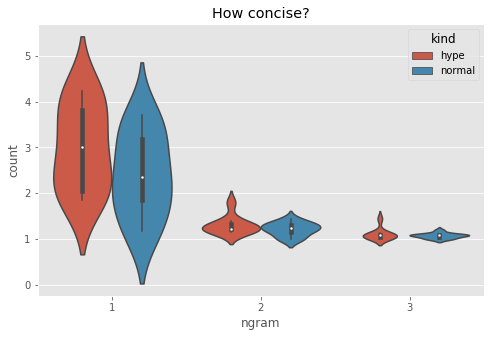

In [146]:
mldf['kind'] = 'hype'
cpudf['kind'] = 'standard'
df = pd.DataFrame([[count, n, kind]
                   for kind, df in [('hype', mldf), ('normal', cpudf)]
                   for n in range(4)
                   for count in df.loc[df.ngram == n].groupby('doc')['count'].mean()])
df.columns = ['count', 'ngram', 'kind']
plt.figure(figsize=(8, 5))
sns.violinplot(x='ngram', y='count', hue='kind', data=df)
plt.title('How concise?')

Let's see how different each article is from the others?

Text(0.5,1,'How varied?')

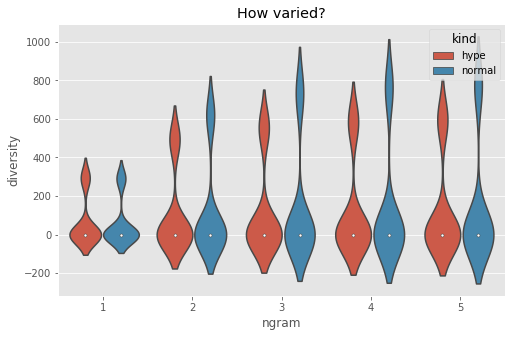

In [149]:
mldf['kind'] = 'hype'
cpudf['kind'] = 'standard'

def variety(df):
    multisets = defaultdict(dict)
    docids = set(df.doc.values)
    for ngram in sorted(df.ngram.unique()):
        part = df.loc[df.ngram == ngram]
        for docid in docids:
            part = part.loc[part.doc == docid]
            for _, row in part.iterrows():
                multisets[docid, ngram][row.tpl] = 1
    rows = []
    for ngram in df.ngram.unique():
        for this in docids:
            for other in docids - set([this]):
                a = set(multisets[this, ngram])
                b = set(multisets[other, ngram])
                count = len(a-b) + len(b-a)
                rows.append((ngram, count))
    return pd.DataFrame(rows, columns=['ngram', 'diversity'])


mldfv = variety(mldf)
mldfv['kind'] = 'hype'
cpudfv = variety(cpudf)
cpudfv['kind'] = 'normal'
plt.figure(figsize=(8, 5))
sns.violinplot(x='ngram', y='diversity', data=pd.concat([mldfv, cpudfv]), hue='kind')
plt.title('How varied?')